# Capstone Project - The Battle of the Neighborhoods (Week 2)

### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Collecting Data](#collecting_data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project, we will try to find an optimal location for a new business office for a company in the city of **Paris**.

Paris is a very active city and many companies choose to do locate their businesses here.
- Our first criterion will be the **budget** : we will be interested in looking at areas with **low to medium rent cost**.
- Second Criterion will be **transportation** : We want the location to be **easily accessible by the metro (subway)**, which is the most used mean of transportation in Paris
- Third and last, we will be looking at **venues** surrounding the area. More particularly, **restaurants**. Companies would want locations where their employees have diverse options for lunch break. Since a happy employee is more productive, this can benefit the company in the long term.

We will use data science to analyse the available data about Paris's neighborhoods and, based on the criteria we defined, we will recommand a list of promising neighborhoods.

## Data <a name="data"></a>

Based on how we defined our problem, these are the factors that will influence our recommandation :
- Price of rent for each neighborhood
- Number of metro stations of each neighborhood
- Number of restaurants in the neighborhood

These are the data sources that we will need to extract/generate the required information:
- Paris neighborhood data : latitude and longitude of each neighborhood's center, neighborhood name, corresponding arrondissement (or borough) ...  : **opendata.paris.fr**
- Parisian metro stations geo data : latitude and longitude of each station : **dataratp.opendatasoft.com/**
- Rent cost per neighborhood in Paris data : **opendata.paris.fr**
- Number of restaurants and their location in every neighborhood will be obtained using **Foursquare API**

## Collecting Data <a name="collecting_data"></a>

In [1]:
import pandas as pd
import folium
from geopy.distance import distance
import requests

### Extracting Paris neighborhoods locations data :

In [2]:
import json
#Importing Paris neighborhood data
with open('Paris_neighborhoods.json') as json_file:
    neighborhood_data = json.load(json_file)


In [3]:
rows = [neighborhood_data[i]['fields'] for i in range(len(neighborhood_data))]

df = pd.DataFrame(columns = rows[0].keys())
df = df.append(rows, ignore_index = True)
df.head()

,n_sq_qu,perimetre,geom_x_y,c_qu,surface,l_qu,geom,n_sq_ar,c_quinsee,c_ar
0,750000021,2391.122818,"[48.8543844036, 2.34003537113]",21,2.933606e+05,Monnaie,"{'type': 'Polygon', 'coordinates': [[[2.343168...",750000006,7510601,6
1,750000022,3516.314464,"[48.8478006293, 2.33633882759]",22,7.161484e+05,Odéon,"{'type': 'Polygon', 'coordinates': [[[2.336988...",750000006,7510602,6
2,750000029,5480.652870,"[48.8670744922, 2.30865168468]",29,1.140254e+06,Champs-Elysées,"{'type': 'Polygon', 'coordinates': [[[2.306463...",750000008,7510801,8
3,750000051,6814.373288,"[48.8231278057, 2.35243314954]",51,2.231506e+06,Maison-Blanche,"{'type': 'Polygon', 'coordinates': [[[2.349115...",750000013,7511303,13
4,750000052,3289.230480,"[48.8337336761, 2.34767304607]",52,6.920677e+05,Croulebarbe,"{'type': 'Polygon', 'coordinates': [[[2.351662...",750000013,7511304,13


In [4]:
df.drop(['geom','n_sq_ar','c_quinsee','n_sq_qu','perimetre'],axis =1,inplace = True)

df[['Latitude','Longitude']] = pd.DataFrame(df.geom_x_y.values.tolist(), index= df.index)


In [5]:
cols = [ 'l_qu','c_qu', 'c_ar', 'Latitude', 'Longitude','geom_x_y','surface']
df = df[cols]
df.rename(columns = {'l_qu' : 'Neighborhood','c_qu' : 'Neighborhood_id','c_ar' : 'Arrondissement'},inplace = True)
df.sort_values(by = ['Neighborhood_id'],ignore_index = True,inplace = True)
df.head()

,Neighborhood,Neighborhood_id,Arrondissement,Latitude,Longitude,geom_x_y,surface
0,Saint-Germain-l'Auxerrois,1,1,48.860650,2.334910,"[48.8606501352, 2.33491032928]",869000.664564
1,Halles,2,1,48.862289,2.344899,"[48.8622891081, 2.34489885831]",412458.496330
2,Palais-Royal,3,1,48.864660,2.336309,"[48.8646599781, 2.33630891897]",273696.793301
3,Place-Vendôme,4,1,48.867019,2.328582,"[48.8670185906, 2.32858166493]",269456.780599
4,Gaillon,5,2,48.869307,2.333432,"[48.8693066381, 2.33343180766]",188012.203850


Let's look at a map of Paris with markers on the center of each neighborhood :

In [6]:
latitude = 48.8534
longitude = 2.3488
# create map
paris_map = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lon, poi in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    folium.CircleMarker(
    [lat, lon],
    radius=5,
    popup=poi,
    fill=True,
    fill_opacity=0.7).add_to(paris_map)

paris_map

### Extracting Paris rent data :

In [7]:
df_rent = pd.read_csv('paris_rent.csv',sep = ';')
df_rent.head()

,Secteurs géographiques,Numéro du quartier,Nom du quartier,Nombre de pièces principales,Epoque de construction,Type de location,Loyers de référence,Loyers de référence majorés,Loyers de référence minorés,Année,Ville,Numéro INSEE du quartier,geo_shape,geo_point_2d
0,1,23,Notre-Dame-des-Champs,4,Apres 1990,non meublé,29.2,35.0,20.4,2017,PARIS,7510623,"{""type"": ""Polygon"", ""coordinates"": [[[2.336756...","48.846427594,2.32735687823"
1,2,24,Saint-Germain-des-Prés,4,Avant 1946,non meublé,25.4,30.5,17.8,2017,PARIS,7510624,"{""type"": ""Polygon"", ""coordinates"": [[[2.336959...","48.85528872,2.33365686809"
2,2,13,Saint-Merri,4,Apres 1990,non meublé,26.4,31.7,18.5,2017,PARIS,7510413,"{""type"": ""Polygon"", ""coordinates"": [[[2.352623...","48.8585213723,2.35166696714"
3,4,14,Saint-Gervais,1,1971-1990,meublé,32.9,39.5,23.0,2017,PARIS,7510414,"{""type"": ""Polygon"", ""coordinates"": [[[2.363764...","48.8557186509,2.35816233385"
4,2,15,Arsenal,1,1946-1970,meublé,35.9,43.1,25.1,2017,PARIS,7510415,"{""type"": ""Polygon"", ""coordinates"": [[[2.368512...","48.851585175,2.36476795387"


In [8]:
df_rent = df_rent[['Numéro du quartier','Loyers de référence']]
df_rent = df_rent.sort_values(by = 'Numéro du quartier').groupby('Numéro du quartier').mean()
df_rent.reset_index(inplace =True)
df_rent.rename(columns = {'Numéro du quartier' : 'Neighborhood_id','Loyers de référence' : 'Average_rent_per_m2'},inplace=True)
df_rent.head()

,Neighborhood_id,Average_rent_per_m2
0,1,27.915625
1,2,24.865625
2,3,27.915625
3,4,27.915625
4,5,27.915625


### Extracting Paris metro locations data :

In [9]:
#Importing Paris metro stations data
with open('paris_metro_stations.json') as json_file1 :
    metro_data = json.load(json_file1)

In [10]:
rows_metro = [metro_data[i]['fields'] for i in range(len(metro_data))]

df_metro = pd.DataFrame(columns = rows_metro[0].keys())
df_metro = df_metro.append(rows_metro, ignore_index = True)

In [11]:
df_metro.head()

,res_stif,cod_ligf,nom_iv,objectid,tertrain,cod_resf,tertram,id_ref_zdl,navette,gares_id,...,metro,terval,geo_point_2d,indice_lig,mode,nomlong,idf,x,idrefliga,idrefligc
0,110.0,14.0,Botzaris,3,0,3.0,0,42369,0,93,...,1,0,"[48.8794817719, 2.38911580738]",7b,Metro,BOTZARIS,1,655197.2716,A01550,NaN
1,110.0,4.0,Assemblée Nationale,27,0,3.0,0,45704,0,30,...,1,0,"[48.8607869635, 2.32099819195]",12,Metro,ASSEMBLEE NATIONALE,1,650183.7135,A01545,NaN
2,110.0,15.0,Balard,31,0,3.0,0,45357,0,47,...,1,0,"[48.8359308792, 2.27816167128]",8,Metro,BALARD,1,647015.7484,A01541,NaN
3,110.0,1.0,Bastille,34,0,3.0,0,42288,0,54,...,1,0,"[48.8524794228, 2.36932058493]",1,Metro,BASTILLE,1,653721.5234,A01534,NaN
4,110.0,12.0,Bel-Air,37,0,3.0,0,45222,0,59,...,1,0,"[48.8413382509, 2.40091853812]",6,Metro,BEL-AIR,1,656030.6977,A01539,NaN


In [12]:
df_metro = df_metro[['nomlong','geo_point_2d','mode']]

In [13]:
df_metro = df_metro [df_metro['mode'] == 'Metro']

In [14]:
df_metro.rename(columns ={'nomlong' : 'Name','geo_point_2d':'geo_x_y'},inplace = True)

df_metro.reset_index(inplace=True,drop=True)
df_metro = df_metro[['Name','geo_x_y']]

df_metro.head(10)

,Name,geo_x_y
0,BOTZARIS,"[48.8794817719, 2.38911580738]"
1,ASSEMBLEE NATIONALE,"[48.8607869635, 2.32099819195]"
2,BALARD,"[48.8359308792, 2.27816167128]"
3,BASTILLE,"[48.8524794228, 2.36932058493]"
4,BEL-AIR,"[48.8413382509, 2.40091853812]"
5,BERCY,"[48.8403887481, 2.37991127145]"
6,CRETEIL-L'ECHAT (HOPITAL MONDOR),"[48.7967407666, 2.44943317569]"
7,AUSTERLITZ,"[48.842436797, 2.365184812]"
8,DAUMESNIL,"[48.8394454284, 2.39618288645]"
9,DUROC,"[48.8470525545, 2.31642435206]"


### Extracting nearby venues data for each neighborhood :

In [15]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
CLIENT_ID = 'C4AX10SRIKNPLOHPL0QY1JU35KV5D0FA0IAOX3JG0JWI4MHA'
CLIENT_SECRET = 'T32AHCCIJXGQ31WEFHQQFDFD4RO24MLBO3MAUQVORVKQEMRO'
VERSION = '20180604'

Let's define a function that gets a venues category

In [16]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


Let's define a function that gets the nearby venues for each neighborhood using Foursquare API :

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print('venues extracted successfully')
    return(nearby_venues)

Now we use the function created on our dataset :

In [21]:
paris_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

venues extracted successfully


In [22]:
paris_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Saint-Germain-l'Auxerrois,48.86065,2.33491,Musée du Louvre,48.860847,2.336440,Art Museum
1,Saint-Germain-l'Auxerrois,48.86065,2.33491,La Vénus de Milo (Vénus de Milo),48.859943,2.337234,Exhibit
2,Saint-Germain-l'Auxerrois,48.86065,2.33491,Vestige de la Forteresse du Louvre,48.861577,2.333508,Historic Site
3,Saint-Germain-l'Auxerrois,48.86065,2.33491,Cour Napoléon,48.861172,2.335088,Plaza
4,Saint-Germain-l'Auxerrois,48.86065,2.33491,"Pavillon des Sessions – Arts d'Afrique, d'Asie...",48.860724,2.332121,Art Museum


Since we are only interested in restaurants, let's create a new dataframe that only contains the nearby restaurants :

In [23]:
restaurant_words = ['Restaurant', 'Diner', 'Taverna', 'Steakhouse']
pattern = '|'.join(restaurant_words)
paris_restaurants = paris_venues[paris_venues['Venue Category'].str.contains(pattern)].reset_index(drop = True)
paris_restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Saint-Germain-l'Auxerrois,48.86065,2.33491,LouLou,48.862804,2.333500,Italian Restaurant
1,Saint-Germain-l'Auxerrois,48.86065,2.33491,Nodaiwa,48.864354,2.333157,Japanese Restaurant
2,Saint-Germain-l'Auxerrois,48.86065,2.33491,Sanukiya,48.864713,2.333805,Udon Restaurant
3,Saint-Germain-l'Auxerrois,48.86065,2.33491,Voltaire (Le),48.859215,2.330344,French Restaurant
4,Saint-Germain-l'Auxerrois,48.86065,2.33491,Le Carrousel,48.863737,2.332099,French Restaurant


## Methodology <a name="methodology"></a>

In this project, we will direct our efforts towards identifying **areas of Paris** that have : **low to medium rent cost**, a **high number of metro stations** nearby and **high restaurant density**.

In the first step, we have collected **the required data** : Paris **Neighborhood geolocation data**, **paris metro geolocation data**, **rent cost data** and the **location of restaurants** near every neighborhood. After exploring the criteria one by one. We will create clusters of locations based on all 3 criteria

Now that we have all our data. We can start **analysing** it. We will explore the different data we extracted and look for insights related to the **3 criteria** that we defined.

In the third and final steps, we will focus on the most promising areas.

## Analysis <a name="analysis"></a>

### Exploring the rent cost data

In [24]:
df_rent.head()

,Neighborhood_id,Average_rent_per_m2
0,1,27.915625
1,2,24.865625
2,3,27.915625
3,4,27.915625
4,5,27.915625


Let's look at a choropleth map of Paris representing the rent cost per square meter per neighborhood.

In [25]:
paris_map_rent = folium.Map(location=[latitude, longitude], zoom_start=12)
folium.Choropleth(
    geo_data='quartier_paris.geojson',
    data=df_rent,
    columns=['Neighborhood_id', 'Average_rent_per_m2'],
    key_on='feature.properties.c_qu',
    fill_color='PuBuGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Rent cost per square meter'
).add_to(paris_map_rent)
paris_map_rent

We can see that the areas with high rent are located towards **the center of city and the west side** of it. Since we are interested in low to medium rent cost, we will be more interested in the other neighborhoods.

Let's add the rent cost to our neighborhoods dataframe :

In [26]:
df['Rent'] = df_rent['Average_rent_per_m2']
df.head()

,Neighborhood,Neighborhood_id,Arrondissement,Latitude,Longitude,geom_x_y,surface,Rent
0,Saint-Germain-l'Auxerrois,1,1,48.860650,2.334910,"[48.8606501352, 2.33491032928]",869000.664564,27.915625
1,Halles,2,1,48.862289,2.344899,"[48.8622891081, 2.34489885831]",412458.496330,24.865625
2,Palais-Royal,3,1,48.864660,2.336309,"[48.8646599781, 2.33630891897]",273696.793301,27.915625
3,Place-Vendôme,4,1,48.867019,2.328582,"[48.8670185906, 2.32858166493]",269456.780599,27.915625
4,Gaillon,5,2,48.869307,2.333432,"[48.8693066381, 2.33343180766]",188012.203850,27.915625


### Exploring the metro stations data

In [27]:
df_metro.head()

,Name,geo_x_y
0,BOTZARIS,"[48.8794817719, 2.38911580738]"
1,ASSEMBLEE NATIONALE,"[48.8607869635, 2.32099819195]"
2,BALARD,"[48.8359308792, 2.27816167128]"
3,BASTILLE,"[48.8524794228, 2.36932058493]"
4,BEL-AIR,"[48.8413382509, 2.40091853812]"





Let's create a function that associates a given metro station to the closest neighborhood :

In [28]:
def associateStation(i) :
    distances_to_neighborhoods = []
    for j in range (len(df)) :
        distances_to_neighborhoods.append(distance(df_metro.iloc[i,1],df.iloc[j,5]))
    return distances_to_neighborhoods.index(min(distances_to_neighborhoods))

Creating a list of neighborhood indexes and adding them to our dataframe :

In [29]:
neighborhood_index = []
for i in range(len(df_metro)) :
    neighborhood_index.append(associateStation(i))

In [30]:
df_metro['Neighborhood_index']= neighborhood_index

df_metro.head()

,Name,geo_x_y,Neighborhood_index
0,BOTZARIS,"[48.8794817719, 2.38911580738]",74
1,ASSEMBLEE NATIONALE,"[48.8607869635, 2.32099819195]",25
2,BALARD,"[48.8359308792, 2.27816167128]",59
3,BASTILLE,"[48.8524794228, 2.36932058493]",14
4,BEL-AIR,"[48.8413382509, 2.40091853812]",46


Let's count the number of stations for each neighborhood and add a new column to our neighborhoods dataframe :

In [31]:
number_of_stations = []
for i in range(len(df)) :
    number_of_stations.append(len(df_metro['Neighborhood_index'][df_metro['Neighborhood_index']==i]))
df['Number_of_stations'] = number_of_stations

df.head()

,Neighborhood,Neighborhood_id,Arrondissement,Latitude,Longitude,geom_x_y,surface,Rent,Number_of_stations
0,Saint-Germain-l'Auxerrois,1,1,48.860650,2.334910,"[48.8606501352, 2.33491032928]",869000.664564,27.915625,1
1,Halles,2,1,48.862289,2.344899,"[48.8622891081, 2.34489885831]",412458.496330,24.865625,4
2,Palais-Royal,3,1,48.864660,2.336309,"[48.8646599781, 2.33630891897]",273696.793301,27.915625,3
3,Place-Vendôme,4,1,48.867019,2.328582,"[48.8670185906, 2.32858166493]",269456.780599,27.915625,5
4,Gaillon,5,2,48.869307,2.333432,"[48.8693066381, 2.33343180766]",188012.203850,27.915625,4


let's convert this to a number of stations per km² (density) :

In [32]:
df['Number_of_stations'] = (df['Number_of_stations']/df['surface'])*1000000
df.head()

,Neighborhood,Neighborhood_id,Arrondissement,Latitude,Longitude,geom_x_y,surface,Rent,Number_of_stations
0,Saint-Germain-l'Auxerrois,1,1,48.860650,2.334910,"[48.8606501352, 2.33491032928]",869000.664564,27.915625,1.150747
1,Halles,2,1,48.862289,2.344899,"[48.8622891081, 2.34489885831]",412458.496330,24.865625,9.697945
2,Palais-Royal,3,1,48.864660,2.336309,"[48.8646599781, 2.33630891897]",273696.793301,27.915625,10.961035
3,Place-Vendôme,4,1,48.867019,2.328582,"[48.8670185906, 2.32858166493]",269456.780599,27.915625,18.555851
4,Gaillon,5,2,48.869307,2.333432,"[48.8693066381, 2.33343180766]",188012.203850,27.915625,21.275215


Let's look at a choropleth map of the density of stations per neighborhood :

In [33]:
paris_map_ch = folium.Map(location=[latitude, longitude], zoom_start=12)
folium.Choropleth(
    geo_data='quartier_paris.geojson',
    data=df,
    columns=['Neighborhood', 'Number_of_stations'],
    key_on='feature.properties.l_qu',
    fill_color='PuBuGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of metro stations per square kilometer',
    threshold_scale=[0,2.5,5,7.5,10,30]
).add_to(paris_map_ch)
paris_map_ch

We can notice the presence of many neighborhoods that have relatively high metro stations density and that are located in the areas of the city where rent is low (East, south east, north east and north). This increases our chance of finding promising neighborhoods that meet our requirements.

### Exploring nearby restaurants data :

In [34]:
paris_restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Saint-Germain-l'Auxerrois,48.86065,2.33491,LouLou,48.862804,2.333500,Italian Restaurant
1,Saint-Germain-l'Auxerrois,48.86065,2.33491,Nodaiwa,48.864354,2.333157,Japanese Restaurant
2,Saint-Germain-l'Auxerrois,48.86065,2.33491,Sanukiya,48.864713,2.333805,Udon Restaurant
3,Saint-Germain-l'Auxerrois,48.86065,2.33491,Voltaire (Le),48.859215,2.330344,French Restaurant
4,Saint-Germain-l'Auxerrois,48.86065,2.33491,Le Carrousel,48.863737,2.332099,French Restaurant


Let's group these restaurants per neighborhood and look at our top 10 neighborhoods :

In [35]:
number_of_restaurants = paris_restaurants.groupby('Neighborhood').count()
number_of_restaurants = number_of_restaurants['Neighborhood Latitude'].rename('Number of nearby restaurants').sort_values(ascending = False)
number_of_restaurants.head(10)

Neighborhood
Gros-Caillou              50
Batignolles               49
Faubourg-Montmartre       48
Saint-Victor              44
Arts-et-Métiers           42
Hôpital-Saint-Louis       42
Gaillon                   41
Ternes                    39
Folie-Méricourt           39
Saint-Germain-des-Prés    38
Name: Number of nearby restaurants, dtype: int64

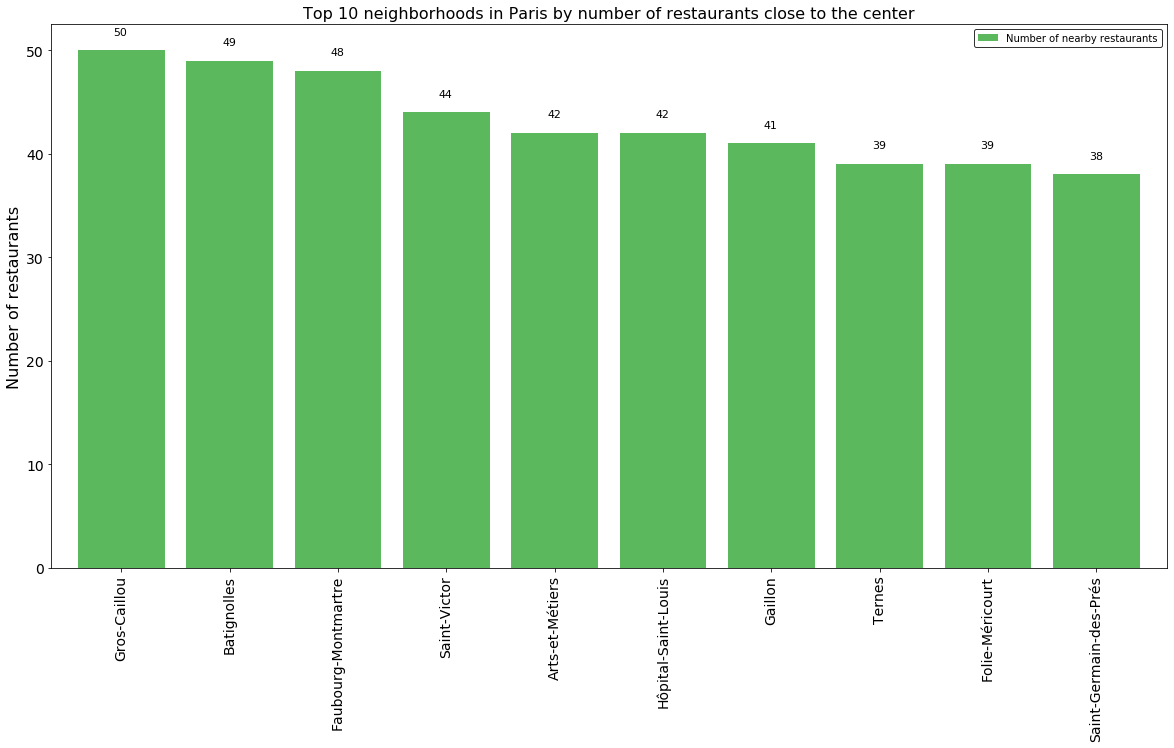

In [88]:
ax = number_of_restaurants.head(10).plot(kind = 'bar',figsize = (20,10),color = '#5cb85c',width = 0.8)

ax.set_title('Top 10 neighborhoods in Paris by number of restaurants close to the center',fontsize =16)
ax.set_ylabel('Number of restaurants',fontsize=16)
ax.set_xlabel('')
ax.tick_params(axis='both', labelsize = 14)
ax.set_facecolor('white')
ax.legend(edgecolor='black',facecolor='white')
#ax.axis('off')
#ax.axes.get_yaxis().set_visible(False)

for i in ax.patches:
    ax.text(i.get_xy()[0] + 0.33,i.get_height() + 1.5,str(i.get_height()),size=11)

Let's add this to our neighborhood data :

In [36]:
df = pd.merge(df, number_of_restaurants,how='left', on=['Neighborhood', 'Neighborhood'])
df['Number of nearby restaurants']= df['Number of nearby restaurants'].fillna(0).astype(int)
df.head()

,Neighborhood,Neighborhood_id,Arrondissement,Latitude,Longitude,geom_x_y,surface,Rent,Number_of_stations,Number of nearby restaurants
0,Saint-Germain-l'Auxerrois,1,1,48.860650,2.334910,"[48.8606501352, 2.33491032928]",869000.664564,27.915625,1.150747,14
1,Halles,2,1,48.862289,2.344899,"[48.8622891081, 2.34489885831]",412458.496330,24.865625,9.697945,14
2,Palais-Royal,3,1,48.864660,2.336309,"[48.8646599781, 2.33630891897]",273696.793301,27.915625,10.961035,36
3,Place-Vendôme,4,1,48.867019,2.328582,"[48.8670185906, 2.32858166493]",269456.780599,27.915625,18.555851,25
4,Gaillon,5,2,48.869307,2.333432,"[48.8693066381, 2.33343180766]",188012.203850,27.915625,21.275215,41


let's transform this to a density (number of restaurants per km²)

In [37]:
df['Number of nearby restaurants'] = (df['Number of nearby restaurants']/df['surface'])*1000000
df.head()

,Neighborhood,Neighborhood_id,Arrondissement,Latitude,Longitude,geom_x_y,surface,Rent,Number_of_stations,Number of nearby restaurants
0,Saint-Germain-l'Auxerrois,1,1,48.860650,2.334910,"[48.8606501352, 2.33491032928]",869000.664564,27.915625,1.150747,16.110459
1,Halles,2,1,48.862289,2.344899,"[48.8622891081, 2.34489885831]",412458.496330,24.865625,9.697945,33.942809
2,Palais-Royal,3,1,48.864660,2.336309,"[48.8646599781, 2.33630891897]",273696.793301,27.915625,10.961035,131.532414
3,Place-Vendôme,4,1,48.867019,2.328582,"[48.8670185906, 2.32858166493]",269456.780599,27.915625,18.555851,92.779257
4,Gaillon,5,2,48.869307,2.333432,"[48.8693066381, 2.33343180766]",188012.203850,27.915625,21.275215,218.070951


In [89]:
paris_map_rest = folium.Map(location=[latitude, longitude], zoom_start=12)
folium.Choropleth(
    geo_data='quartier_paris.geojson',
    data=df,
    columns=['Neighborhood', 'Number of nearby restaurants'],
    key_on='feature.properties.l_qu',
    fill_color='PuBuGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of metro stations per square kilometer',
    threshold_scale=[0,10,20,30,40,300]
).add_to(paris_map_rest)
paris_map_rest


We notice many neighborhoods with relatively high restaurant density in the eastern side of paris and a few more south an north. This is coherent with our rent and metro stations density criteria.

### Clustering neighborhoods :

In [41]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [42]:
X = df[['Rent','Number_of_stations','Number of nearby restaurants']]
X = StandardScaler().fit_transform(X)
X[:5]

array([[ 1.0551262 , -0.87364949, -0.55748535],
       [-0.21822043,  0.652161  , -0.13160508],
       [ 1.0551262 ,  0.87764244,  2.1990742 ],
       [ 1.0551262 ,  2.23343774,  1.2735537 ],
       [ 1.0551262 ,  2.71888721,  4.26582682]])

In [52]:
num_clusters = 3

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(X)
labels = k_means.labels_

print(labels)

[2 1 0 0 0 0 2 0 0 0 0 0 0 2 2 2 2 1 2 2 0 2 2 0 2 2 2 2 2 2 2 2 1 2 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]


In [53]:
df['Cluster'] = labels

In [54]:
df.head()

,Neighborhood,Neighborhood_id,Arrondissement,Latitude,Longitude,geom_x_y,surface,Rent,Number_of_stations,Number of nearby restaurants,Cluster
0,Saint-Germain-l'Auxerrois,1,1,48.860650,2.334910,"[48.8606501352, 2.33491032928]",869000.664564,27.915625,1.150747,16.110459,2
1,Halles,2,1,48.862289,2.344899,"[48.8622891081, 2.34489885831]",412458.496330,24.865625,9.697945,33.942809,1
2,Palais-Royal,3,1,48.864660,2.336309,"[48.8646599781, 2.33630891897]",273696.793301,27.915625,10.961035,131.532414,0
3,Place-Vendôme,4,1,48.867019,2.328582,"[48.8670185906, 2.32858166493]",269456.780599,27.915625,18.555851,92.779257,0
4,Gaillon,5,2,48.869307,2.333432,"[48.8693066381, 2.33343180766]",188012.203850,27.915625,21.275215,218.070951,0


In [46]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [55]:
import numpy as np
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Good results. The clustering shows that one of the clusters (labeled 1) corresponds to neighborhoods situatuated the promising areas that we found by analysing the data and exploring the 3 criteria.
Now, we will be interested in the neighborhoods of this particular cluster in order to make recommandations

In [56]:
df_recommand = df[df['Cluster']==1]
df_recommand.reset_index(inplace=True,drop = True)
df_recommand=df_recommand[['Neighborhood','Neighborhood_id','Rent','Number_of_stations','Number of nearby restaurants','Latitude','Longitude']]
df_recommand

,Neighborhood,Neighborhood_id,Rent,Number_of_stations,Number of nearby restaurants,Latitude,Longitude
0,Halles,2,24.865625,9.697945,33.942809,48.862289,2.344899
1,Jardin-des-Plantes,18,24.787500,2.505043,31.313041,48.841940,2.356894
2,Saint-Georges,33,24.865625,11.156176,34.863051,48.879934,2.332850
3,Rochechouart,36,24.865625,5.994780,59.947796,48.879812,2.344861
4,Saint-Vincent-de-Paul,37,24.865625,9.710150,19.420299,48.880735,2.357471
5,Porte-Saint-Denis,38,24.865625,6.354403,69.898431,48.873618,2.352283
6,Porte-Saint-Martin,39,23.687500,1.641943,37.764682,48.871245,2.361504
7,Hôpital-Saint-Louis,40,23.687500,2.263145,47.526043,48.876008,2.368123
8,Folie-Méricourt,41,23.687500,5.511521,53.737328,48.867403,2.372965
9,Saint-Ambroise,42,24.787500,3.579983,36.993153,48.862345,2.376118


Our cluster still seems to be quite large and needs refinement.
Since rent cost is our first criterion, well will only remove the rows with rent superior than the mean value :

In [57]:
df_recommand = df_recommand[df_recommand['Rent']< df_recommand['Rent'].mean()]

Let's also remove neighborhoods with values that are too low :

In [58]:
df_recommand = df_recommand[df_recommand['Number of nearby restaurants']> df_recommand['Number of nearby restaurants'].mean()]

In [59]:
df_recommand

,Neighborhood,Neighborhood_id,Rent,Number_of_stations,Number of nearby restaurants,Latitude,Longitude
14,Bercy,47,22.4375,5.255048,6.831562,48.835209,2.386210
30,Grandes-Carrières,69,22.8750,2.099114,12.069906,48.892578,2.334363
31,Clignancourt,70,22.8750,3.628194,11.489282,48.891668,2.345979
33,La Chapelle,72,20.6000,3.710452,7.420905,48.894012,2.364387
34,Villette,73,20.6000,5.444484,11.666751,48.887661,2.374468
35,Pont-de-Flandre,74,20.6000,2.104166,7.574998,48.895556,2.384777
37,Combat,76,22.4375,1.544416,12.355328,48.878639,2.380127
40,Père-Lachaise,79,22.4375,2.501560,8.130071,48.863719,2.395273


Let's place our results on a map :

In [60]:
recommand_map = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lon, poi in zip(df_recommand['Latitude'], df_recommand['Longitude'], df_recommand['Neighborhood']):
    folium.CircleMarker(
    [lat, lon],
    radius=5,
    popup=poi,
    fill=True,
    fill_opacity=0.7).add_to(recommand_map)

recommand_map

The map shows that the recommanded neighborhoods are located north east of Paris.

## Results and Discussion <a name="results"></a>

Our analysis of Paris neighborhoods was aimed at making a recommendation for a new business office location based on rent, accessibility via the metro and nearby restaurants.
Exploring these criteria and analysing our data showed us that :
- Rent is higher in the center of Paris and towards its west side
- Metro stations density is very high in the center and relatively high in the east side of the city
- Paris has many ares of relatively high restaurant density, particularly north east,east and south east.

Clustering our data based on these 3 criteria confirmed our observations and gave us a cluster of neighborhoods situated more towards the east side (east, north east and south east) that contains neighborhoods that meet our requirements.

Now that we directed our attention to this cluster, we noticed that it was relatively big and that it needed some refinement. We removed neighborhoods that had high rent values and very low restaurant density values compared to the rest of the cluster.

Result of all this is 8 neighborhoods that meet the defined criteria and answer our business needs. Most of these neighborhoods are located north east of Paris.

Although data analysis gave us satisfying results, these neighborhoods might not be optimal because of criteria that we did not define in this problem (like crime rate for example). But these results still represent a good starting point and a good first recommendation for a business office location.


## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Paris areas that are suitable for opening a new business office in order to aid stakeholders in narrowing down the search for optimal location. By looking at rent cost in different neighborhoods, we started identifying our target areas. Then, by calculating metro stations density and restraurants density, we obtained promising results that confirm what we find out during data exploration. This allowed us to narrow down our search to certain areas. Clustering of Paris neighborhoods was then performed in order confirm our results and to create major zones of interest and locations to be used as starting points for final exploration by stakeholders.

Final decision on optimal location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.